# Network Intrusion Detection with Deep Learning

menggunakan stacked AE tanpa pretraining AE di hidden layer 1 dan 2, full sae MLP dengan input= 122 di seluruh layer AE

https://github.com/jay07121993/stacked-Autoencoder/blob/master/Greedy%20pre-training%20Stacked%20auto%20encoder.ipynb

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,3" #model will be trained on GPU 0

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Open Data

In [3]:
import numpy as np
def load_matrices(file_name):
    with open(file_name, 'rb') as f:
        A = np.load(f)
        B = np.load(f)
        C = np.load(f)
        D = np.load(f)
        E = np.load(f)
        F = np.load(f)
    return (A,B,C,D,E,F)

In [14]:
my_file = '../data_NSL/data.npy'
train, test, test2, y_train, y_test, y_test2 = load_matrices(my_file)

## The Model

In [4]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation#, Merge, Reshape, Dropout
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [6]:
# We apply a fairly simple MLP architecture

In [5]:
from keras.callbacks import ModelCheckpoint
filepath="./logae/weights_fullae_d.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]
filepath2="./logae/weights_fullae_2d.best.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_acc', save_best_only=True, mode='max')
callbacks_list2 = [checkpoint2]


In [8]:
# We use early stopping on a holdout validation set

In [6]:
#from keras.layers.advanced_activations import ELU
from keras.activations import elu


def selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * elu(x, alpha)

#model.add(Dense(32, input_shape=(input_length - 1,)), activation=selu)

In [9]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential,load_model
from time import time
from keras.activations import relu, elu
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

In [11]:
# layer 1
input_dim = train.shape[1]
input_ly_1= Input(shape=(input_dim,))
enc_ly_1= Dense(20, activation= 'relu', kernel_initializer='he_uniform')(input_ly_1)
dec_ly_1=Dense(input_dim, activation='sigmoid', kernel_initializer='he_uniform')(enc_ly_1)

auto_ly_1= Model(input_ly_1, dec_ly_1)
encoder_ly_1= Model(input_ly_1, enc_ly_1)
auto_ly_1.summary()


t0 = time()
auto_ly_1.compile(loss='mse',optimizer='adam', metrics=['accuracy']) # reporting the loss

auto_ly_1.fit(train,train,
      epochs=50,
      batch_size=256,
      shuffle=True,
      callbacks=callbacks_list,                    
      #callbacks=[early_stopping])
      validation_data=(test,test))
      #validation_split=0.2)   
  
tt = time()-t0
print ("FEATURE EXTRACTION in {} seconds".format(round(tt,3)))
# if you want an encoded flatten representation of every test MNIST


ly1_predict= encoder_ly_1.predict(train)
print(ly1_predict.shape)


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 122)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2460      
_________________________________________________________________
dense_2 (Dense)              (None, 122)               2562      
Total params: 5,022
Trainable params: 5,022
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 125973 samples, validate on 22544 samples
Epoch 1/50
125973/125973 [==============================] - 2s 20us/step - loss: 0.0591 - acc: 0.3007 - val_loss: 0.0141 - val_acc: 0.1041
Epoch 2/50
125973/125973 [==============================] - 1s 11us/step - loss: 0.0084 - acc:

In [12]:
# define new model encoder->Dense  22 neurons with soft max for classification 

# Deep stacked auto encoder
ly_1= auto_ly_1.layers[1].get_weights()
#ly_2= auto_ly_2.layers[1].get_weights()
#ly_3= auto_ly_3.layers[1].get_weights()

input_da= Input(shape=(input_dim,))
dnn_1=Dense(20, activation='relu',  kernel_initializer='he_uniform',input_shape=(input_dim,),
            name="layer1")(input_da)
dnn_2= Dense(10, activation='relu', kernel_initializer='he_uniform',name="layer2")(dnn_1)
dnn_3= Dense(10, activation='relu', kernel_initializer='he_uniform',name="layer3")(dnn_2)
dnn_4= Dense(10, activation='relu', kernel_initializer='he_uniform',name="layer4")(dnn_3)

dnn_5= Dense(5, activation='softmax',kernel_initializer='he_uniform')(dnn_4)

dnn= Model(input_da, dnn_5)
dnn.summary()

dnn.layers[1].set_weights(ly_1) # first dense layer
#dnn.layers[2].set_weights(ly_2)
#dnn.layers[3].set_weights(ly_3)


t1=time()
dnn.compile(loss='categorical_crossentropy', metrics=['accuracy'],
            optimizer= Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0, amsgrad=False))
history2a=dnn.fit(train, y_train,epochs=100,batch_size=256,shuffle=True,verbose=1, 
                    callbacks=callbacks_list2, 
                     # validation_split=0)
                     validation_data=(test,y_test))
tt2 = time()-t1
print ("FEATURE CLASSIFICATION in {} seconds".format(round(tt2,3)))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
layer1 (Dense)               (None, 20)                2460      
_________________________________________________________________
layer2 (Dense)               (None, 10)                210       
_________________________________________________________________
layer3 (Dense)               (None, 10)                110       
_________________________________________________________________
layer4 (Dense)               (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________
Train on

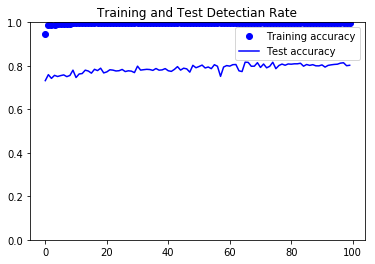

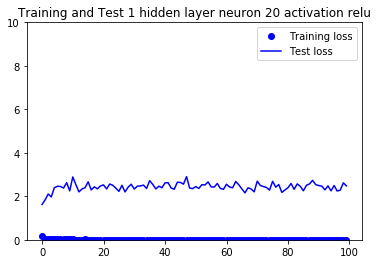

In [37]:
accuracy_2a = history2a.history['acc']
val_accuracy_2a = history2a.history['val_acc']
loss_2a = history2a.history['loss']
val_loss_2a = history2a.history['val_loss']
epochs = range(len(accuracy_2a))
plt.plot(epochs, accuracy_2a, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_2a, 'b', label='Test accuracy')
plt.ylim(bottom=0, top=1.0)  # this line
plt.title('Training and Test Detectian Rate')
plt.legend()
plt.figure()
plt.plot(epochs, loss_2a, 'bo', label='Training loss')
plt.plot(epochs, val_loss_2a, 'b', label='Test loss')
plt.ylim(bottom=0, top=10.0)  # this line
plt.title('Training and Test 1 hidden layer neuron 20 activation relu')
plt.legend()
plt.show()

In [38]:
dnn.evaluate(test,y_test)

22544/22544 [==============================] - 0s 15us/step


[2.3409156009523135, 0.816847054648687]

In [39]:
# 4. evaluate the network
loss, val_accuracy = dnn.evaluate(train,y_train)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, val_accuracy*100))

125973/125973 [==============================] - 2s 14us/step

Loss: 0.01, Accuracy: 99.85%


In [40]:
# 4. evaluate the network
loss, val_accuracy = dnn.evaluate(test,y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, val_accuracy*100))

22544/22544 [==============================] - 0s 15us/step

Loss: 2.34, Accuracy: 81.68%


## The Performance

In [10]:
from sklearn.metrics import confusion_matrix


In [11]:
##loading autoencoder untuk data tes
# load weights
#autoencoder.load_weights("./log2/talos_weights_tes_a.best.hdf5")

# Compile model (required to make predictions)
#autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#print("Created model and loaded weights from file")
#scores = autoencoder.evaluate(test, test, verbose=0)
#print("%s: %.2f%%" % (autoencoder.metrics_names[1], scores[1]*100))

In [12]:
from time import time


In [16]:
##loading autoencoder untuk data tes
# load weights
# load weights
dnn=load_model(filepath2)
dnn.load_weights(filepath2)
# Compile model (required to make predictions)
dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
t1=time()
scores = dnn.evaluate(test, y_test, verbose=1)
tt2 = time()-t1
print("%s: %.2f%%" % (dnn.metrics_names[1], scores[1]*100))
print ("prediction in {} seconds".format(round(tt2,3)))

Created model and loaded weights from file
22544/22544 [==============================] - 1s 23us/step
acc: 81.68%
prediction in 0.51 seconds


In [21]:
scores = dnn.evaluate(test, y_test, verbose=0)
print("%s: %.2f%%" % (dnn.metrics_names[1], scores[1]*100))



acc: 81.68%


In [22]:
preds = dnn.predict(test)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(y_test, axis=1)
# With the confusion matrix, we can aggregate model predictions
# This helps to understand the mistakes and refine the model

In [23]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
from sklearn.metrics import confusion_matrix


In [25]:
confusion_matrix(true_lbls, pred_lbls)

array([[6266,  547,  645,    0,    0],
       [  89, 9386,  227,    3,    6],
       [ 196,  134, 2084,    7,    0],
       [   1, 2013,   60,  657,   23],
       [   3,  145,    2,   28,   22]], dtype=int64)

In [26]:
from sklearn.metrics import f1_score
f1_score(true_lbls, pred_lbls, average='weighted')

0.7948732208997663

In [27]:
# Overall, we report similar model performance to the reference above.
# Their research suggest using unsupervised pretraining with autoencoders over
# both train and test before adding classifier layers for fine-tuning.
# I have done no parameter tuning but report comparable performance.
# Note the model has diffuculty with U2R and R2L.

In [28]:
from sklearn.metrics import classification_report
outcomes = ['DoS', 'normal' ,'Probe' ,'U2R','R2L' ]
class_names=outcomes

target_names = ["Class {}".format(i) for i in range(5)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))


              precision    recall  f1-score   support

         DoS    0.95591   0.84017   0.89431      7458
      normal    0.76777   0.96653   0.85576      9711
       Probe    0.69052   0.86080   0.76632      2421
         U2R    0.94532   0.23856   0.38098      2754
         R2L    0.43137   0.11000   0.17530       200

    accuracy                        0.81685     22544
   macro avg    0.75818   0.60321   0.61453     22544
weighted avg    0.84042   0.81685   0.79487     22544



Confusion matrix, without normalization
[[6266  547  645    0    0]
 [  89 9386  227    3    6]
 [ 196  134 2084    7    0]
 [   1 2013   60  657   23]
 [   3  145    2   28   22]]


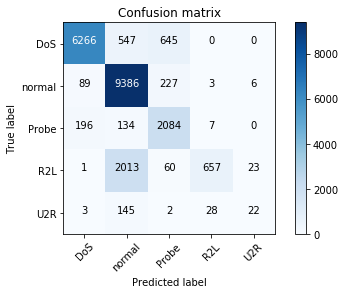

In [29]:

outcomes = ['DoS', 'normal','Probe' ,'R2L', 'U2R']
class_names=outcomes


results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))

In [30]:
###Data Train

In [31]:
dnn.load_weights(filepath2)
# Compile model (required to make predictions)
dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
scores = dnn.evaluate(train, y_train, verbose=0)
print("%s: %.2f%%" % (dnn.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
acc: 99.85%


In [32]:
preds = dnn.predict(train)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(y_train, axis=1)
# With the confusion matrix, we can aggregate model predictions
# This helps to understand the mistakes and refine the model

In [33]:
confusion_matrix(true_lbls, pred_lbls)

array([[45927,     0,     0,     0,     0],
       [   10, 67232,    52,    33,    16],
       [    2,    26, 11628,     0,     0],
       [    0,    45,     0,   949,     1],
       [    0,     2,     0,     3,    47]], dtype=int64)

In [34]:
from sklearn.metrics import f1_score
f1_score(true_lbls, pred_lbls, average='weighted')

0.9984992563345978

In [35]:

target_names = ["Class {}".format(i) for i in range(5)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

         DoS    0.99974   1.00000   0.99987     45927
      normal    0.99892   0.99835   0.99863     67343
       Probe    0.99555   0.99760   0.99657     11656
         R2L    0.96345   0.95377   0.95859       995
         U2R    0.73438   0.90385   0.81034        52

    accuracy                        0.99849    125973
   macro avg    0.93841   0.97071   0.95280    125973
weighted avg    0.99851   0.99849   0.99850    125973



Confusion matrix, without normalization
[[45927     0     0     0     0]
 [   10 67232    52    33    16]
 [    2    26 11628     0     0]
 [    0    45     0   949     1]
 [    0     2     0     3    47]]


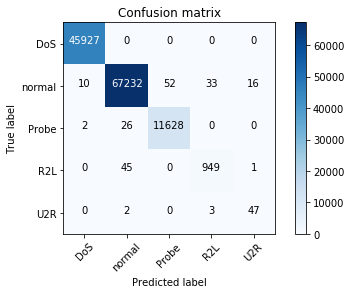

In [36]:


results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))